# Gasto Público em Educação x Desempenho no PISA


O objetivo deste trabalho é avaliar possíveis correlações entre o gasto público de um país em educação e o desempenho dos alunos deste país na prova do Programa Internacional de Avaliação de Estudantes (PISA). Todas as informações necessárias foram baixadas no site de dados da OCDE [aqui](https://data.oecd.org/), onde é possível encontrar o histórico dos indicadores pertinentes em formato csv. 

Vale notar que por gasto público em educação nos referimos à porcentagem do PIB investida pelo país na educação primária e secundária. O desempenho do país no PISA, por sua vez, faz referência à nota de cada país na prova e está dividido em três bases, uma para cada área do conhecimento avaliada: Leitura, Matemática e Ciência. Maiores informações a respeito do PISA podem ser encontradas [aqui](http://portal.inep.gov.br/pisa), no site do INEP.

### Divisão do Trabalho

0. Importação das Bibliotecas
1. Input das Bases
2. Tratamento das Bases
3. Unificação das Bases
4. Análise Exploratória dos Dados
5. Correlação entre Gasto Público em Educação x Desempenho no PISA


## 0. Importação das Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns
import plotly.figure_factory as ff
import plotly.express as px

## 1. Input das Bases

In [144]:
#Gasto Público em Educação
gp_educ = pd.read_csv('gasto_publico_educ_00-15.csv')

#Desempenho no PISA
#Matemática
pisa_m = pd.read_csv('pisa_mat_03-18.csv')
#Leitura
pisa_l = pd.read_csv('pisa_leitura_00-18.csv')
#Ciência
pisa_c = pd.read_csv('pisa_sci_06-18.csv')

## 2. Tratamento das Bases

In [145]:
#Selecionando apenas colunas pertinentes
gp_educ.drop(['INDICATOR','SUBJECT','MEASURE','FREQUENCY','Flag Codes'],axis=1,inplace=True)

pisa_m.drop(['INDICATOR','SUBJECT','MEASURE','FREQUENCY','Flag Codes'],axis=1,inplace=True)
pisa_l.drop(['INDICATOR','SUBJECT','MEASURE','FREQUENCY','Flag Codes'],axis=1,inplace=True)
pisa_c.drop(['INDICATOR','SUBJECT','MEASURE','FREQUENCY','Flag Codes'],axis=1,inplace=True)

#Com isso, todas as bases contêm apenas o nome do país, o valor do indicador e o ano.

In [146]:
#Renomeando as colunas para maior comodidade 
gp_educ.columns = ['País','Ano','Gasto Educ (%)']
pisa_m.columns = ['País','Ano','Nota Matemática']
pisa_l.columns = ['País','Ano','Nota Leitura']
pisa_c.columns = ['País','Ano','Nota Ciências']

In [147]:
#Avaliando se as colunas estão sendo lidas corretamente. Ano e Valor devem ser lidos como números inteiros (int)
#ou fracionados (float)

print(gp_educ.dtypes)
print()
print(pisa_m.dtypes)
print()
print(pisa_c.dtypes)
print()
print(pisa_l.dtypes)

País               object
Ano                 int64
Gasto Educ (%)    float64
dtype: object

País               object
Ano                 int64
Nota Matemática     int64
dtype: object

País             object
Ano               int64
Nota Ciências     int64
dtype: object

País            object
Ano              int64
Nota Leitura     int64
dtype: object


## 3. Unificação das Bases

In [148]:
#Para unificar as bases, precisamos de uma coluna para usar de referência. Como os valores fazem referência a um país e a um ano
#simultaneamente, vamos concatenar a coluna país com a coluna ano. Com isso, essa coluna concatenada poderá ser usada para 
#cruzar as bases sem perda de informação.

gp_educ['País-Ano'] = gp_educ['País'] + '-' + gp_educ['Ano'].astype(str)

pisa_m['País-Ano'] = pisa_m['País'] + '-' + pisa_m['Ano'].astype(str)
pisa_l['País-Ano'] = pisa_l['País'] + '-' + pisa_l['Ano'].astype(str)
pisa_c['País-Ano'] = pisa_c['País'] + '-' + pisa_c['Ano'].astype(str)

In [149]:
#Concatenando as bases
base = pd.concat([gp_educ,pisa_m,pisa_l,pisa_c],axis=0,sort=False)
#Com isso, a variável 'base' estará agrupada, mas terá valores repetidos para o país-ano 
#(duas linhas para Brasil-2005, por exemplo)

#Para termos apenas um valor para cada país-ano, vamos agrupar a base na coluna País-Ano utilizando como função a mínimo. 
#Poderíamos aqui utilizar outras funções que não a mínimo, pois só existe 1 valor de cada indicador para cada país-ano.
#Se fizessemos a função max(), por exemplo, o resultado seria o mesmo, pois o mínimo de [nan,nan,x] é igual ao
#máximo de [nan,nan,x], já que só possui um valor - nan não conta.

base_group = base.groupby('País-Ano').min()

## 4. Análise Exploratória dos Dados

Nesta seção, vamos buscar entender o comportamento das bases. Antes de mais nada, veremos quais são as estatísticas descritivas da base.

In [151]:
base_group.describe()[['Gasto Educ (%)', 'Nota Matemática', 'Nota Leitura','Nota Ciências']]

#Antes de mais nada, percebemos que o count das colunas não é igual. Isto significa que não existem todos os indicadores,
#todos os anos para todos os países. Isto é um problema, pois implica que precisaremos lidar com esses espaços vazios.

#Quanto ao Gasto Público em educação, percebemos que existe uma amplitude grande - de 1.5% à 5.1% de investimento -, com uma 
#média de 3.29%

#Já as notas do PISA possuem médias muito parecidas, entre 485 e 490 pontos.

,Gasto Educ (%),Nota Matemática,Nota Leitura,Nota Ciências
count,369.000000,236.000000,263.000000,202.000000
mean,3.293992,486.792373,485.866920,490.480198
std,0.693616,41.084077,34.442027,36.536115
min,1.543000,356.000000,371.000000,382.000000
25%,2.747000,480.750000,476.000000,478.000000
50%,3.238000,494.500000,493.000000,497.000000
75%,3.754000,512.000000,506.500000,513.000000
max,5.158000,564.000000,556.000000,563.000000


Text(0.5, 0.98, 'Distribuição das Variáveis')

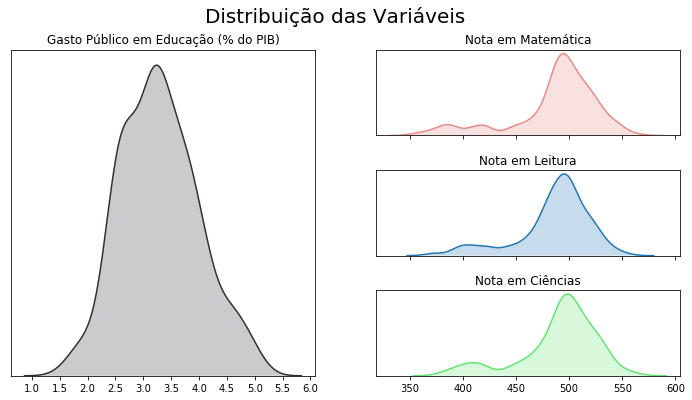

In [280]:
#Vamos visualizar as distribuições dessas colunas.
fig = plt.figure(figsize=(12,6))

#Gerando um espaço de imagem do matplotlib
gs = gridspec.GridSpec(3, 2, wspace=0.2, hspace=0.4,figure=fig)

#Criando os sub-espaços (1 maior, e 3 menores)
#No código abaixo estamos forçando os gráficos do PISA a terem todos os mesmo eixo X.
ax0 = fig.add_subplot(gs[0, 1])
plt.yticks([])
plt.yticks([])
plt.title('Nota em Matemática')
plt.setp(ax0.get_xticklabels(), visible=False)

ax1 = fig.add_subplot(gs[1, 1],sharex=ax0)
plt.yticks([])
plt.title('Nota em Leitura')
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = fig.add_subplot(gs[2, 1],sharex=ax0)
plt.yticks([])
plt.title('Nota em Ciências')

ax3 = fig.add_subplot(gs[:, 0])
plt.yticks([])
plt.xticks([x/100 for x in range(100,700,50)])
plt.title('Gasto Público em Educação (% do PIB)')

#Plotando os gráficos de distribuição.
sns.distplot(base_group['Gasto Educ (%)'],ax=ax3,hist=False,axlabel=False,kde_kws={"shade": True},color='#342d36')
sns.distplot(base_group['Nota Matemática'],ax=ax0,hist=False,axlabel=False,kde_kws={"shade": True},color='#eb8989')
sns.distplot(base_group['Nota Leitura'],ax=ax1,hist=False,kde_kws={"shade": True},axlabel=False)
sns.distplot(base_group['Nota Ciências'],ax=ax2,hist=False,axlabel=False,kde_kws={"shade": True},color='#62e571')

fig.suptitle('Distribuição das Variáveis',fontsize=20)